In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 250)
sns.set_theme(style='whitegrid')

### Analyze all endothelium SRA sizes

In [2]:
df_sra_sizes = pd.read_csv("../TranscriptomicsAtlas/data/SRA_IDs/SRAAccListSizes.csv")
df_sra_sizes["size [GB]"] = df_sra_sizes["size [B]"] / 1024**3
df_sra_sizes.describe()

,size [B],size [GB]
count,1.460000e+03,1460.000000
mean,1.884132e+09,1.754735
std,3.225732e+09,3.004197
min,6.607834e+06,0.006154
25%,4.714679e+08,0.439089
50%,7.155744e+08,0.666431
75%,2.121023e+09,1.975356
max,6.998240e+10,65.176186


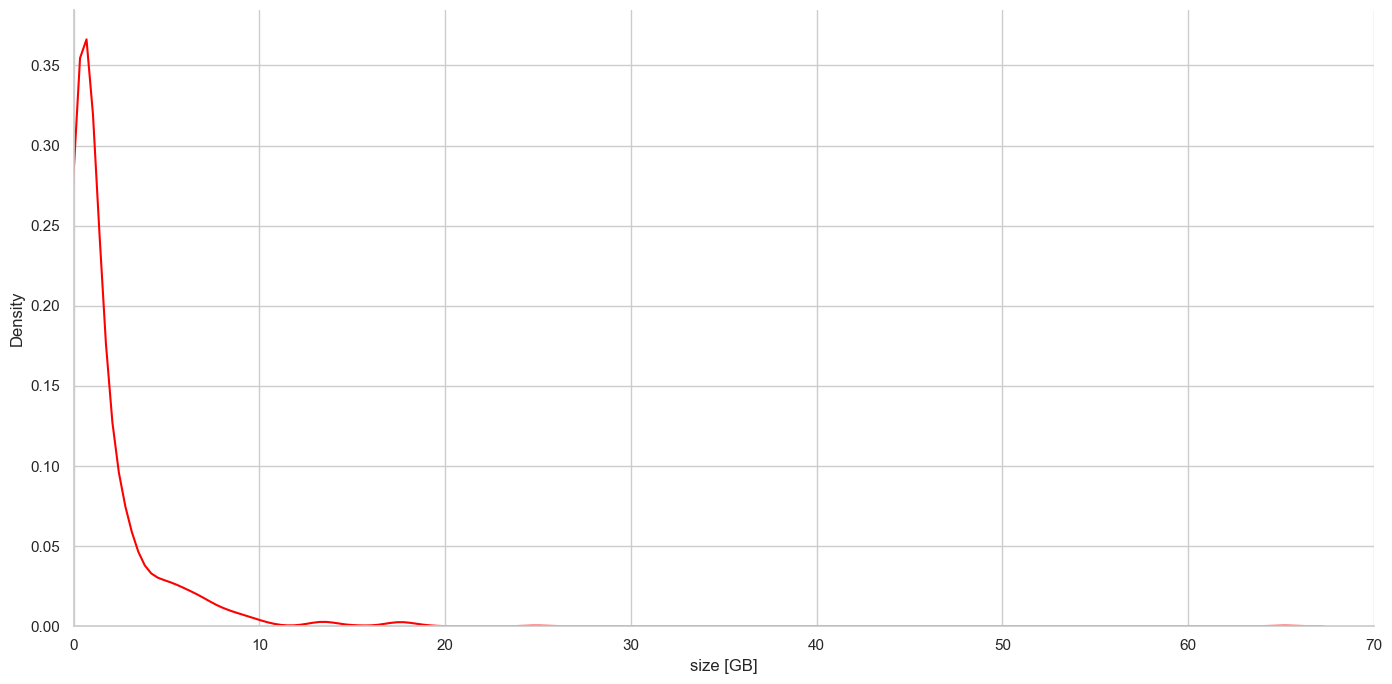

In [3]:
sns.displot(data=df_sra_sizes, x="size [GB]", kind="kde", height=7, aspect=2, color="red").set(xlim=(0,70));

### Analyze experiment sample of SRA_IDs

In [4]:
with open("../TranscriptomicsAtlas/data/SRA_IDs/random_99_small_SRA_IDs.txt", "r") as f:
    random_99_small = [sra_id.strip() for sra_id in f.readlines()]
df_random_99_small = df_sra_sizes[df_sra_sizes["srr_id"].isin(random_99_small)]
df_random_99_small.describe()

,size [B],size [GB]
count,9.900000e+01,99.000000
mean,1.337797e+09,1.245920
std,1.478128e+09,1.376614
min,9.536050e+06,0.008881
25%,4.741979e+08,0.441631
50%,6.102390e+08,0.568329
75%,1.554934e+09,1.448145
max,7.263902e+09,6.765036


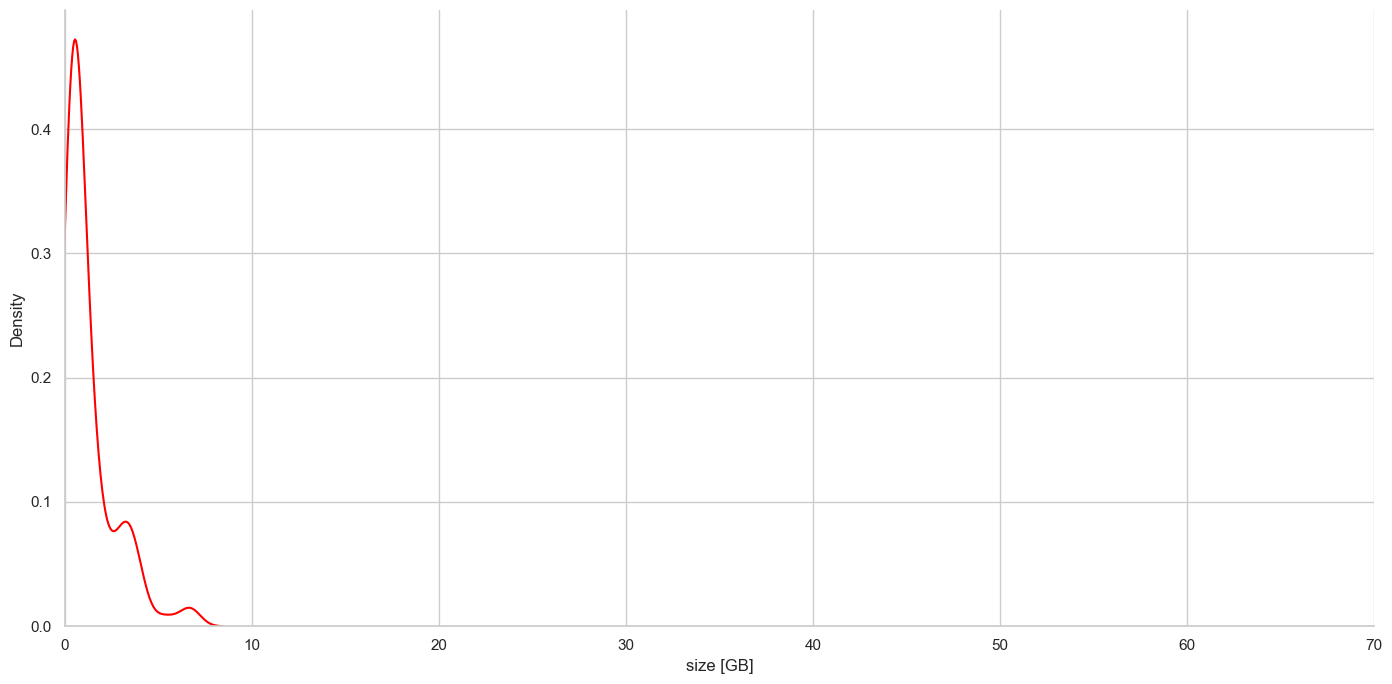

In [5]:
sns.displot(data=df_random_99_small, x="size [GB]", kind="kde", height=7, aspect=2, color="red").set(xlim=(0, 70));

# Load and parse metrics data and metadata

In [6]:
def load_metadata_to_dict(dir):
    metadata = {}

    for filename in os.listdir(dir):
        if filename.endswith('.json'):
            filepath = os.path.join(dir, filename)
            with open(filepath, 'r') as file:
                sra_id = filename.split("_")[0]
                data = json.load(file)
                metadata[sra_id] = data

    return metadata

In [7]:
def load_metrics_to_df(dir):
    instances_metrics = {}

    for filename in os.listdir(dir):
        if filename.endswith('.csv'):
            filepath = os.path.join(dir, filename)
            with open(filepath, 'r') as file:
                instance_id = filename.split(".")[0]
                data = pd.read_csv(file, float_precision='round_trip', parse_dates=["Timestamp"], index_col=0)
                instances_metrics[instance_id] = data

    return instances_metrics

In [8]:
def get_single_step_metrics(instances_metrics, step_name, metadata):
    instance_id = metadata["instance_id"]
    metrics = instances_metrics[instance_id]
    start_time = metadata["timestamps"][step_name]["start_time"]
    end_time = metadata["timestamps"][step_name]["end_time"]
    step_metrics = metrics[(metrics['Timestamp'] >= start_time) & (metrics['Timestamp'] <= end_time)]

    return step_metrics

# get_single_step_metrics(ec2_metrics, "salmon", all_metadata["DRR023416"])

In [9]:
def get_all_step_metrics(instances_metrics, step_name, all_metadata):
    step_metrics = []
    for srr_id, metadata in all_metadata.items():
        metadata["instance_id"] = metadata["instance_id"].replace("/", "_")
        metrics = pd.DataFrame(get_single_step_metrics(instances_metrics, step_name, metadata))
        if metrics.empty:  # Beware of this line
            metrics.loc[0] = {"procstat_cpu_time_user [None]": 0}
        metrics["instance_id"] = metadata["instance_id"]
        metrics["srr_id"] = srr_id
        step_metrics.append(metrics)

    df = pd.concat(step_metrics).reset_index(drop=True)
    df['time_since_start [s]'] = df.groupby('srr_id')['Timestamp'].transform(lambda x: x - x.min()).transform(lambda x: x.seconds)

    for col in ['time_since_start [s]', "srr_id"]:
        col = df.pop(col)
        df.insert(0, col.name, col)

    for col in df.columns:
        if "[Bytes]" in col:
            df[col] = df[col] / 1024**2
    df = df.rename(columns=lambda x: x.replace('[Bytes]', '[MB]'))

    return df.drop("instance_id", axis=1).dropna(axis=1, how='all')

In [10]:
def parse_metadata_to_df(all_metadata):
    step_names = ["prefetch", "fasterq_dump", "salmon", "deseq2"]
    parsed_metadata = []

    for srr_id, metadata in all_metadata.items():
        step_times = []
        for step in step_names:
            start_time = datetime.strptime(metadata["timestamps"][step]["start_time"], '%Y-%m-%dT%H:%M:%S')
            end_time = datetime.strptime(metadata["timestamps"][step]["end_time"], '%Y-%m-%dT%H:%M:%S')
            step_times.append((end_time-start_time).seconds)

        srr_metadata = step_times + [metadata["SRR_filesize_bytes"] / 1024**3, metadata["fastq_filesize_bytes"] / 1024**3]
        parsed_metadata.append(srr_metadata)

    df_metadata = pd.DataFrame(parsed_metadata, columns=[name + " [s]" for name in step_names]+["sra_filesize [GB]", "fastq_filesize [GB]"])
    df_metadata.index = all_metadata.keys()

    return df_metadata

## Cloud experiment metadata analysis

In [11]:
ec2_metadata = load_metadata_to_dict("metadata/2023-07-05-cloud")
ec2_metrics = load_metrics_to_df("metric_data/2023-07-05-cloud")
ec2_df = parse_metadata_to_df(ec2_metadata)
ec2_df.describe()

,prefetch [s],fasterq_dump [s],salmon [s],deseq2 [s],sra_filesize [GB],fastq_filesize [GB]
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,37.858586,83.434343,578.151515,10.898990,1.245920,8.596210
std,42.847144,86.700771,530.453971,4.496019,1.376614,8.764412
min,1.000000,0.000000,15.000000,9.000000,0.008881,0.057070
25%,14.000000,14.000000,147.500000,9.000000,0.441631,2.595878
50%,18.000000,44.000000,421.000000,10.000000,0.568329,4.056225
75%,43.500000,130.000000,757.500000,10.000000,1.448145,10.852495
max,234.000000,342.000000,2575.000000,36.000000,6.765036,38.778340


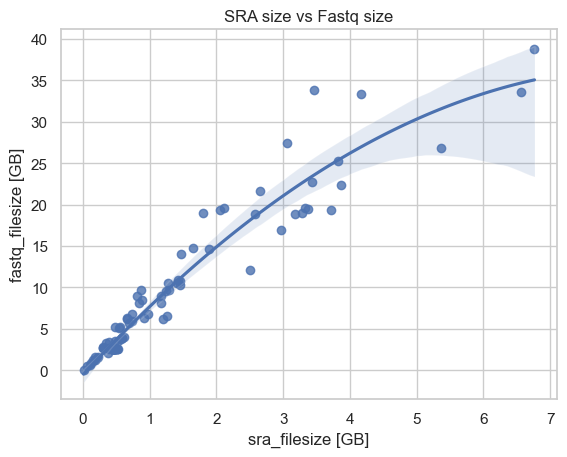

In [12]:
sns.regplot(data=ec2_df, x="sra_filesize [GB]", y="fastq_filesize [GB]", order=2).set_title('SRA size vs Fastq size');

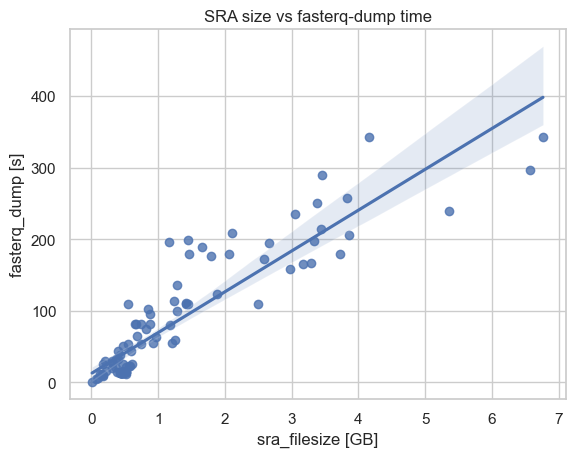

In [13]:
sns.regplot(data=ec2_df, x="sra_filesize [GB]", y="fasterq_dump [s]", order=1).set_title('SRA size vs fasterq-dump time');

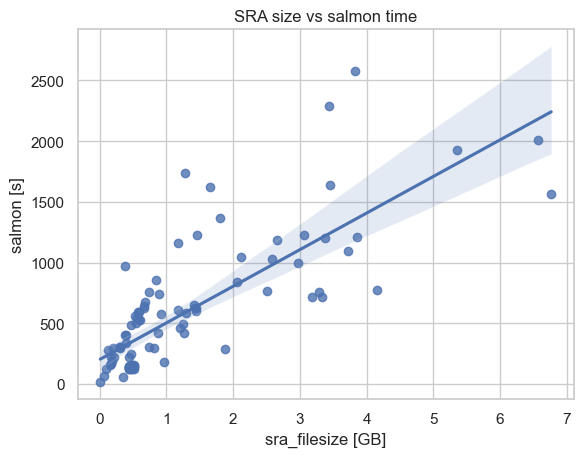

In [14]:
sns.regplot(data=ec2_df, x="sra_filesize [GB]", y="salmon [s]", order=1).set_title('SRA size vs salmon time');

## Cloud experiment metrics analysis

In [15]:
prefetch_ec2_metrics = get_all_step_metrics(ec2_metrics, "prefetch", ec2_metadata)
prefetch_ec2_metrics.groupby("srr_id").agg(["min", "mean", "max"]).agg(["mean", "max"])

time_since_start [s]                                                   Timestamp                                                                         cpu_usage_idle [Avg] [%]                       cpu_usage_iowait [Avg] [%]              
                      min        mean         max                                 min                                mean                                 max                      min       mean        max                        min       mean   
mean                  0.0   15.638298   31.276596 2023-07-05 11:43:43.936170240+00:00 2023-07-05 11:43:59.574467840+00:00 2023-07-05 11:44:15.212765952+00:00                54.910279  70.331794  79.770497                   1.229811   3.727888  \
max                   0.0  115.000000  230.000000           2023-07-05 12:53:10+00:00 2023-07-05 12:54:05.000000256+00:00           2023-07-05 12:55:00+00:00                86.800855  86.800855  89.625105                  15.850635  23.061436   

                cpu_usage_user [Avg] [%]                       disk_used_percent [Avg] [%]                       diskio_io_time [Max] [ms]                            diskio_read_bytes [Sum] [MB]                          diskio_reads [Sum] [n]   
            max                      min       mean        max                         min       mean        max                       min         mean           max                          min        mean          max                    min   
mean   8.415948                14.859187  21.559357  35.376806                   50.340837  50.387583  50.473732                349.148936  1091.628627   2292.978723                     0.757355   13.229152   104.667522              15.265957  \
max   47.054900                58.912396  58.912396  69.650000                   53.662835  53.730280  53.879484               3208.000000  5784.000000  10008.000000                    17.218750  582.990153  4716.375000             400.000000   

                                diskio_write_bytes [Sum] [MB]                           diskio_writes [Sum] [n]                            mem_used [Avg] [MB]                         mem_used_percent [Avg] [%]                       
             mean           max                           min         mean          max                     min         mean           max                 min        mean         max                        min      mean       max   
mean   131.991849    914.787234                    103.498005   546.355204  1186.400100              490.744681  2318.037807   4929.425532          311.551280  322.671307  338.373005                   4.013003  4.156237  4.358487  \
max   4671.750000  37914.000000                   1318.664062  1560.007812  3058.992188             5598.000000  6511.000000  12340.000000          374.597656  374.597656  409.332031                   4.825089  4.825089  5.272493   

     net_bytes_recv [Sum] [MB]                         net_bytes_sent [Sum] [MB]                     net_packets_recv [Sum] [n]                              net_packets_sent [Sum] [n]                             swap_used_percent [Avg] [%]        
                           min        mean         max                       min      mean       max                        min          mean            max                        min          mean           max                         min mean   
mean                206.951579  299.117344  348.276687                  0.931802  1.368823  1.634494              125828.106383  181328.54008  210032.074468               16080.893617  23881.567843  28158.478723                         0.0  0.0  \
max                 409.152721  421.899238  454.429887                  2.540849  3.503529  4.539259              294175.000000  314956.00000  339303.000000               49239.000000  67791.318182  88143.000000                         0.0  0.0   

          procstat_cpu_time [Max] []                  procstat_cpu_time_idle [Max] []           procstat_cpu_

In [16]:
prefetch_ec2_metrics.describe()

,time_since_start [s],cpu_usage_idle [Avg] [%],cpu_usage_iowait [Avg] [%],cpu_usage_user [Avg] [%],disk_used_percent [Avg] [%],diskio_io_time [Max] [ms],diskio_read_bytes [Sum] [MB],diskio_reads [Sum] [n],diskio_write_bytes [Sum] [MB],diskio_writes [Sum] [n],mem_used [Avg] [MB],mem_used_percent [Avg] [%],net_bytes_recv [Sum] [MB],net_bytes_sent [Sum] [MB],net_packets_recv [Sum] [n],net_packets_sent [Sum] [n],swap_used_percent [Avg] [%],procstat_cpu_time [Max] [],procstat_cpu_time_idle [Max] [],procstat_cpu_time_iowait [Max] [],procstat_cpu_time_user [Max] [],procstat_cpu_usage [Avg] [%],procstat_memory_rss [Avg] [MB],procstat_memory_swap [Avg] [MB],procstat_memory_vms [Avg] [MB],procstat_num_threads [Max] [],procstat_read_bytes [Sum] [MB],procstat_read_count [Sum] [],procstat_write_bytes [Sum] [MB],procstat_write_count [Sum] []
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.0,386.000000,386.0,386.0,386.000000,274.000000,386.000000,386.0,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,38.067010,73.562019,4.950528,17.048876,50.305099,1297.175258,64.846473,541.314433,625.263893,2603.595361,321.759766,4.144496,320.947101,1.651220,204521.020619,30097.180412,0.0,11.370466,0.0,0.0,9.406658,27.436411,11.580463,0.0,64.118220,1.673575,42.797867,4343.121762,1569.867785,140274.121762
std,45.194105,16.460160,7.755396,13.787867,3.450810,1941.525275,482.904141,3871.520678,693.899599,2829.539561,20.763256,0.267446,98.775275,0.931077,96762.178099,18924.456207,0.0,11.411776,0.0,0.0,8.680715,6.307966,12.527472,0.0,116.422866,1.498805,406.515777,17493.402012,1497.400696,160260.685607
min,0.000000,2.866667,0.000000,7.722272,39.312485,4.000000,0.000000,0.000000,0.000000,0.000000,275.902344,3.553818,0.000072,0.000086,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.310000,19.801562,6.417969,0.0,11.621094,1.000000,0.000000,430.000000,22.648438,22.000000
25%,10.000000,71.244715,0.050042,9.887197,50.724418,31.000000,0.000000,0.000000,0.953125,22.000000,307.814453,3.964872,289.861437,0.969788,135966.500000,14015.250000,0.0,3.000000,0.0,0.0,3.195000,23.931121,6.550781,0.0,11.851562,1.000000,0.000000,686.000000,515.284180,28898.250000
50%,20.000000,79.043511,1.030540,11.055593,50.798367,410.000000,0.000000,0.000000,280.703125,1296.000000,319.171875,4.111163,355.136564,1.445529,250674.500000,25624.500000,0.0,8.000000,0.0,0.0,6.825000,26.150089,6.582031,0.0,11.855469,1.000000,0.343750,686.000000,1030.781250,86197.000000
75%,60.000000,84.653225,8.095987,16.206078,51.121305,1953.000000,0.179688,10.000000,1130.113281,4717.500000,333.560547,4.296497,387.564158,2.353548,278903.000000,45124.750000,0.0,15.750000,0.0,0.0,12.525000,28.804297,6.656250,0.0,11.859375,1.000000,3.492188,686.000000,2207.292969,194384.250000
max,230.000000,89.625105,47.054900,69.650000,53.879484,10008.000000,4716.375000,37914.000000,3058.992188,12340.000000,409.332031,5.272493,454.429887,4.539259,339303.000000,88143.000000,0.0,59.000000,0.0,0.0,47.010000,78.803719,68.324219,0.0,324.558594,5.000000,5956.398438,191415.000000,6927.453125,808747.000000


### Prefetch insights:
- (instance) CPU usage: mean = 21%, max = 70%
- (instance) CPU usage iowait: mean = 3.7%, max = 47%
- (instance) MEM usage: max = 323MB, max = 410MB
- (procstat) MEM vms: mean = 120MB, max = 325MB
- (procstat) n_threads: mean = 2.4, max = 5

In [17]:
fasterq_ec2_metrics = get_all_step_metrics(ec2_metrics, "fasterq_dump", ec2_metadata)
fasterq_ec2_metrics.groupby("srr_id").agg(["min", "mean", "max"]).agg(["mean", "max"])

time_since_start [s]                                                   Timestamp                                                                         cpu_usage_idle [Avg] [%]                       cpu_usage_iowait [Avg] [%]              
                      min        mean         max                                 min                                mean                                 max                      min       mean        max                        min       mean   
mean                  0.0   37.938144   75.876289 2023-07-05 11:43:48.762886656+00:00 2023-07-05 11:44:26.701030912+00:00 2023-07-05 11:45:04.639175424+00:00                 1.420363   7.845047  17.754592                   4.058272  26.905616  \
max                   0.0  170.000000  340.000000           2023-07-05 12:55:10+00:00           2023-07-05 12:57:55+00:00           2023-07-05 13:00:40+00:00                22.866494  22.866494  39.147749                  43.189815  77.345860   

                cpu_usage_user [Avg] [%]                       disk_used_percent [Avg] [%]                       diskio_io_time [Max] [ms]                           diskio_read_bytes [Sum] [MB]                           diskio_reads [Sum] [n]   
            max                      min       mean        max                         min       mean        max                       min         mean          max                          min         mean          max                    min   
mean  51.890985                26.963808  55.945126  83.274338                   50.642358  51.178266  51.664717               4810.309278  7205.876092   8525.85567                    18.774565   619.317877  1426.317624             112.309278  \
max   91.604301                89.589428  91.177447  94.465750                   54.036904  55.297447  56.228267               9996.000000  9999.000000  10020.00000                   946.804688  1585.866629  3558.007812            4468.000000   

                                 diskio_write_bytes [Sum] [MB]                           diskio_writes [Sum] [n]                            mem_used [Avg] [MB]                         mem_used_percent [Avg] [%]                       
              mean           max                           min         mean          max                     min         mean           max                 min        mean         max                        min      mean       max   
mean   4662.519588  11076.721649                    2585.38845  3303.693996  4061.549855            10580.979381  13466.87957  16800.762887          354.636678  394.779114  505.555211                   4.567974  5.085037  6.511913  \
max   11745.222222  25403.000000                    5406.78125  5406.781250  5406.781250            22030.000000  22030.00000  51072.000000          751.550781  751.550781  759.816406                   9.680508  9.680508  9.786975   

     net_bytes_recv [Sum] [MB]                        net_bytes_sent [Sum] [MB]                     net_packets_recv [Sum] [n]                             net_packets_sent [Sum] [n]                            swap_used_percent [Avg] [%]             
                           min       mean         max                       min      mean       max                        min          mean           max                        min         mean           max                         min mean  max   
mean                  0.444951   4.920559   14.882575                  0.007148  0.033453  0.103519                 338.701031   2658.415865   7739.453608                  62.608247   406.241177   1161.195876                         0.0  0.0  0.0  \
max                  21.484264  73.633255  147.251504                  0.221576  0.400263  1.204967               15774.000000  35535.000000  85895.000000                3330.000000  7608.500000  19026.000000                         0.0  0.0  0.0   

     procstat_cpu_time [Max] []                         procstat_cpu_time_idle [Max] []          

In [18]:
fasterq_ec2_metrics.describe()

,time_since_start [s],cpu_usage_idle [Avg] [%],cpu_usage_iowait [Avg] [%],cpu_usage_user [Avg] [%],disk_used_percent [Avg] [%],diskio_io_time [Max] [ms],diskio_read_bytes [Sum] [MB],diskio_reads [Sum] [n],diskio_write_bytes [Sum] [MB],diskio_writes [Sum] [n],mem_used [Avg] [MB],mem_used_percent [Avg] [%],net_bytes_recv [Sum] [MB],net_bytes_sent [Sum] [MB],net_packets_recv [Sum] [n],net_packets_sent [Sum] [n],swap_used_percent [Avg] [%],procstat_cpu_time [Max] [],procstat_cpu_time_idle [Max] [],procstat_cpu_time_iowait [Max] [],procstat_cpu_time_user [Max] [],procstat_cpu_usage [Avg] [%],procstat_memory_rss [Avg] [MB],procstat_memory_swap [Avg] [MB],procstat_memory_vms [Avg] [MB],procstat_num_threads [Max] [],procstat_read_bytes [Sum] [MB],procstat_read_count [Sum] [],procstat_write_bytes [Sum] [MB],procstat_write_count [Sum] []
count,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.0,833.000000,833.0,833.0,833.000000,724.000000,833.000000,833.0,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000
mean,82.184874,8.670004,36.092732,46.036185,51.466047,8272.033613,1097.697550,8392.376951,3007.386058,12319.650660,355.019784,4.572909,1.890928,0.020885,998.333733,161.106843,0.0,115.504202,0.0,0.0,104.344142,104.402304,76.007878,0.0,358.147467,4.836735,3124.086013,110916.028812,14329.395089,14332.852341
std,73.262105,10.327675,32.516435,38.329289,3.109271,2278.201260,1070.918635,8610.032818,1055.721438,4434.032644,82.037367,1.056700,12.296923,0.065334,6672.793987,1084.078385,0.0,88.753211,0.0,0.0,79.208258,80.272980,188.822554,0.0,196.925376,0.773507,4500.945835,135155.670957,12765.343887,12762.595613
min,0.000000,0.000000,0.000000,0.155460,39.376056,636.000000,0.000000,0.000000,303.765625,1424.000000,291.792969,3.758501,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,2.400055,0.328125,0.0,17.082031,1.000000,0.000000,6.000000,0.000000,0.000000
25%,20.000000,0.133150,0.699717,0.817441,50.949224,7008.000000,105.796875,876.000000,2290.484375,9378.000000,320.628906,4.129932,0.000228,0.000287,4.000000,4.000000,0.0,40.000000,0.0,0.0,38.190000,13.673757,22.843750,0.0,318.906250,5.000000,40.976562,12520.000000,4084.000000,4084.000000
50%,60.000000,2.079331,24.164579,61.160488,51.764621,9328.000000,593.929688,3862.000000,2747.398438,11286.000000,330.863281,4.261758,0.007212,0.005898,26.000000,25.000000,0.0,99.000000,0.0,0.0,90.930000,136.184797,25.531250,0.0,321.300781,5.000000,1075.820312,52646.000000,10493.339844,10493.000000
75%,130.000000,16.585288,72.092122,85.386431,53.659670,9996.000000,2308.604492,18452.000000,3947.507812,16064.000000,354.164062,4.561885,0.008107,0.010662,33.000000,46.000000,0.0,180.000000,0.0,0.0,161.370000,189.819392,47.976562,0.0,323.226562,5.000000,4251.246094,162750.000000,22204.000000,22204.000000
max,340.000000,39.147749,91.604301,94.465750,56.228267,10020.000000,3558.007812,25403.000000,5406.781250,51072.000000,759.816406,9.786975,147.251504,1.204967,85895.000000,19026.000000,0.0,380.000000,0.0,0.0,338.980000,198.358529,1001.859375,0.0,1325.933594,7.000000,25201.027344,646470.000000,58752.082031,58753.000000


### Fasterq-dump insights:
- (instance) CPU usage: mean = 56%, max = 94%
- (instance) CPU usage iowait: mean = 26%, max = 91%
- (instance) MEM usage: mean=394MB, max= 760MB
- (procstat) MEM vms: mean=439MB, max=1326MB
- (procstat) n_threads: mean = 4.9, max = 7

In [19]:
salmon_ec2_metrics = get_all_step_metrics(ec2_metrics, "salmon", ec2_metadata)
salmon_ec2_metrics.groupby("srr_id").agg(["min", "mean", "max"]).agg(["mean", "max"])

time_since_start [s]                                                  Timestamp                                                                         cpu_usage_idle [Avg] [%]                       cpu_usage_iowait [Avg] [%]              
                      min         mean          max                              min                                mean                                 max                      min       mean        max                        min       mean   
mean                  0.0   284.292929   568.585859 2023-07-05 11:44:52.323232+00:00 2023-07-05 11:49:36.616161536+00:00 2023-07-05 11:54:20.909090816+00:00                 0.092894   3.778683  25.227885                   0.019046   1.477410  \
max                   0.0  1280.000000  2560.000000        2023-07-05 13:00:50+00:00           2023-07-05 13:07:10+00:00           2023-07-05 13:15:40+00:00                 9.079821  20.275220  50.075289                   1.885586  31.596774   

                cpu_usage_user [Avg] [%]                       disk_used_percent [Avg] [%]                       diskio_io_time [Max] [ms]                            diskio_read_bytes [Sum] [MB]                          diskio_reads [Sum] [n]   
            max                      min       mean        max                         min       mean        max                       min         mean           max                          min         mean         max                    min   
mean  16.551031                60.314541  93.779039  99.499308                   51.454135  51.863486  51.974643                 15.434343   907.482258   4652.888889                     4.415483   198.315130   770.34953              31.212121  \
max   90.469439                91.910110  98.851191  99.950000                   55.463674  55.463679  55.464246               1032.000000  4527.571429  10004.000000                   332.468750  1032.513773  2855.75000            1734.000000   

                                diskio_write_bytes [Sum] [MB]                          diskio_writes [Sum] [n]                            mem_used [Avg] [MB]                           mem_used_percent [Avg] [%]                         
             mean           max                           min        mean          max                     min         mean           max                 min         mean          max                        min       mean        max   
mean  1542.411209   4607.909091                      0.016177   70.854276  1323.946496                0.121212   356.668921   7654.515152          652.369437   840.409566   953.034328                   8.402985  10.825077  12.275764  \
max   8319.000000  22872.000000                      1.601562  308.756010  3891.218750               12.000000  1753.853659  37394.000000          791.718750  1782.700992  2859.492188                  10.197900  22.962455  36.832291   

     net_bytes_recv [Sum] [MB]                       net_bytes_sent [Sum] [MB]                     net_packets_recv [Sum] [n]                            net_packets_sent [Sum] [n]                           swap_used_percent [Avg] [%]             
                           min      mean         max                       min      mean       max                        min         mean           max                        min        mean           max                         min mean  max   
mean                  0.000119  0.211369    7.751418                  0.000117  0.014828  0.157604                   1.262626   171.747407   5694.070707                   1.292929   48.772577   1282.989899                         0.0  0.0  0.0  \
max                   0.007868  3.819504  104.089751                  0.006650  0.044055  1.512549                  38.000000  2758.130435  76645.000000                  38.000000  547.268293  23844.000000                         0.0  0.0  0.0   

     procstat_cpu_time [Max] []                           procstat_cpu_time_idle [Max] []           procs

In [20]:
salmon_ec2_metrics.describe()

,time_since_start [s],cpu_usage_idle [Avg] [%],cpu_usage_iowait [Avg] [%],cpu_usage_user [Avg] [%],disk_used_percent [Avg] [%],diskio_io_time [Max] [ms],diskio_read_bytes [Sum] [MB],diskio_reads [Sum] [n],diskio_write_bytes [Sum] [MB],diskio_writes [Sum] [n],mem_used [Avg] [MB],mem_used_percent [Avg] [%],net_bytes_recv [Sum] [MB],net_bytes_sent [Sum] [MB],net_packets_recv [Sum] [n],net_packets_sent [Sum] [n],swap_used_percent [Avg] [%],procstat_cpu_time [Max] [],procstat_cpu_time_idle [Max] [],procstat_cpu_time_iowait [Max] [],procstat_cpu_time_user [Max] [],procstat_cpu_usage [Avg] [%],procstat_memory_rss [Avg] [MB],procstat_memory_swap [Avg] [MB],procstat_memory_vms [Avg] [MB],procstat_num_threads [Max] [],procstat_read_bytes [Sum] [MB],procstat_read_count [Sum] [],procstat_write_bytes [Sum] [MB],procstat_write_count [Sum] []
count,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.0,5726.000000,5726.0,5726.0,5726.000000,5629.000000,5726.000000,5726.0,5726.000000,5726.000000,5726.000000,5.726000e+03,5726.000000,5726.000000
mean,524.425628,2.099346,0.890565,95.957012,52.140145,1017.370112,271.915565,2168.375698,29.683112,199.913932,905.106593,11.658420,0.193289,0.015013,158.728701,53.122556,0.0,1027.667831,0.0,0.0,1022.204003,193.004448,1135.563517,0.0,1519.343466,6.533706,8977.573221,5.700403e+05,0.008108,139.277157
std,489.054870,5.768247,6.931333,11.690858,1.979267,1347.449698,265.135590,2020.351074,218.770729,1544.466118,348.029735,4.482872,3.531388,0.046563,2572.839961,633.043231,0.0,967.885080,0.0,0.0,963.218444,23.133712,358.369143,0.0,473.997391,0.919559,8444.437772,5.156061e+05,0.253638,104.244210
min,0.000000,0.000000,0.000000,0.000000,39.377355,0.000000,0.000000,0.000000,0.000000,0.000000,294.964844,3.799361,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.299995,0.003906,0.0,4.800781,1.000000,0.000000,8.900000e+01,0.000000,4.000000
25%,150.000000,0.000000,0.000000,98.400300,51.071311,8.000000,0.000000,0.000000,0.000000,0.000000,793.608398,10.222240,0.000160,0.000189,3.000000,3.000000,0.0,275.000000,0.0,0.0,273.437500,198.392130,1034.167969,0.0,1367.933594,7.000000,1541.485352,1.638865e+05,0.000000,76.000000
50%,380.000000,0.000000,0.000000,99.200200,52.087820,956.000000,302.250000,2438.000000,0.000000,0.000000,818.667969,10.545025,0.007145,0.005857,25.000000,25.000000,0.0,745.000000,0.0,0.0,741.010000,199.292658,1061.066406,0.0,1411.937500,7.000000,6930.128906,4.174780e+05,0.000000,118.000000
75%,750.000000,0.050000,0.000000,99.416775,53.767322,1344.000000,419.755859,3382.000000,0.007812,2.000000,853.522461,10.993979,0.007364,0.006157,29.000000,30.000000,0.0,1464.000000,0.0,0.0,1456.180000,199.495038,1094.991211,0.0,1471.929688,7.000000,14206.258789,8.771050e+05,0.000000,176.000000
max,2560.000000,50.075289,90.469439,99.950000,55.464246,10004.000000,2855.750000,22872.000000,3891.218750,37394.000000,2859.492188,36.832291,104.089751,1.512549,76645.000000,23844.000000,0.0,4986.000000,0.0,0.0,4966.840000,199.898773,3069.601562,0.0,3906.261719,7.000000,40398.375000,2.550044e+06,9.695312,2796.000000


### Salmon insights:
- (instance) CPU usage: mean = 94%, max 100%
- (instance) CPU usage iowait: mean = 1.5%, max = 90%
- (instance) MEM usage: mean = 840MB, max = 2.8GB
- (procstat) MEM vms: mean = 1419MB, max = 3.8GB
- (procstat) n_threads: mean = 6.3, max = 7

In [21]:
deseq2_ec2_metrics = get_all_step_metrics(ec2_metrics, "deseq2", ec2_metadata)
deseq2_ec2_metrics.groupby("srr_id").agg(["min", "mean", "max"]).agg(["mean", "max"])

time_since_start [s]                                                 Timestamp                                                                         cpu_usage_idle [Avg] [%]                       cpu_usage_iowait [Avg] [%]              
                      min       mean        max                                 min                                mean                                 max                      min       mean        max                        min       mean   
mean                  0.0   0.858586   1.717172 2023-07-05 11:54:30.303030016+00:00 2023-07-05 11:54:31.161615872+00:00 2023-07-05 11:54:32.020201472+00:00                53.638902  54.542867  55.556111                   2.304413   3.423279  \
max                   0.0  10.000000  20.000000           2023-07-05 13:15:50+00:00           2023-07-05 13:15:50+00:00           2023-07-05 13:15:50+00:00                71.626125  71.626125  74.412450                  29.507588  37.402804   

                cpu_usage_user [Avg] [%]                       disk_used_percent [Avg] [%]                       diskio_io_time [Max] [ms]                           diskio_read_bytes [Sum] [MB]                           diskio_reads [Sum] [n]   
            max                      min       mean        max                         min       mean        max                       min         mean          max                          min         mean          max                    min   
mean   4.317951                37.874501  39.221724  40.596321                   51.663185  51.697446  51.720483                667.878788   916.760943  1113.737374                    52.801728    55.006971    56.766138             889.777778  \
max   47.187895                57.731558  57.731558  59.324853                   55.278611  55.278611  55.278611               5168.000000  7373.333333  9368.000000                  1084.468750  1084.468750  1084.468750            5728.000000   

                               diskio_write_bytes [Sum] [MB]                         diskio_writes [Sum] [n]                           mem_used [Avg] [MB]                          mem_used_percent [Avg] [%]                         
             mean          max                           min        mean         max                     min         mean          max                 min        mean          max                        min       mean        max   
mean   924.643098   953.878788                     10.374763   11.174650   12.272096              206.747475   216.575758   231.737374          504.225537   532.77057   563.892243                   6.494786   6.862466   7.263336  \
max   5728.000000  5728.000000                    159.898438  159.898438  159.898438             1302.000000  1302.000000  1302.000000         1004.218750  1004.21875  1004.218750                  12.935064  12.935064  12.935064   

     net_bytes_recv [Sum] [MB]                         net_bytes_sent [Sum] [MB]                     net_packets_recv [Sum] [n]                              net_packets_sent [Sum] [n]                             swap_used_percent [Avg] [%]        
                           min        mean         max                       min      mean       max                        min           mean           max                        min          mean           max                         min mean   
mean                 43.084535   48.663530   55.909669                  0.589951  0.642329  0.708435               26477.080808   28948.252525   32001.40404                3365.686869   3739.754209   4186.242424                         0.0  0.0  \
max                 205.142173  205.142173  216.595235                  2.005687  2.005687  2.088068              150053.000000  150053.000000  150053.00000               24079.000000  24079.000000  26226.000000                         0.0  0.0   

          procstat_cpu_time [Max] []                     procstat_cpu_time_idle [Max] []           procstat_cpu_time_iowa

In [22]:
deseq2_ec2_metrics.describe()

,time_since_start [s],cpu_usage_idle [Avg] [%],cpu_usage_iowait [Avg] [%],cpu_usage_user [Avg] [%],disk_used_percent [Avg] [%],diskio_io_time [Max] [ms],diskio_read_bytes [Sum] [MB],diskio_reads [Sum] [n],diskio_write_bytes [Sum] [MB],diskio_writes [Sum] [n],mem_used [Avg] [MB],mem_used_percent [Avg] [%],net_bytes_recv [Sum] [MB],net_bytes_sent [Sum] [MB],net_packets_recv [Sum] [n],net_packets_sent [Sum] [n],swap_used_percent [Avg] [%],procstat_cpu_time [Max] [],procstat_cpu_time_idle [Max] [],procstat_cpu_time_iowait [Max] [],procstat_cpu_time_user [Max] [],procstat_cpu_usage [Avg] [%],procstat_memory_rss [Avg] [MB],procstat_memory_swap [Avg] [MB],procstat_memory_vms [Avg] [MB],procstat_num_threads [Max] [],procstat_read_bytes [Sum] [MB],procstat_read_count [Sum] [],procstat_write_bytes [Sum] [MB],procstat_write_count [Sum] []
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.0,104.000000,104.0,104.0,104.000000,12.000000,104.000000,104.0,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,1.896552,54.228438,6.104751,36.993577,51.643530,1424.620690,53.253536,917.086207,10.566339,201.431034,536.783304,6.914153,47.716999,0.606546,27315.000000,3576.818966,0.0,3.096154,0.0,0.0,3.283654,29.714491,276.778208,0.0,491.778133,2.028846,24.015888,1731.067308,51.618051,5643.057692
std,4.919136,8.679206,11.810332,12.412323,1.839882,2351.027815,109.757714,1037.974663,17.908089,212.274278,276.914000,3.566851,69.477916,0.582300,44850.894698,5754.235465,0.0,3.191370,0.0,0.0,3.145285,16.485142,287.092562,0.0,495.207104,1.018820,56.259979,1252.600040,69.456332,7515.710725
min,0.000000,37.546178,0.000000,2.842258,47.416069,4.000000,0.000000,0.000000,0.000000,0.000000,287.324219,3.700940,0.000044,0.000051,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.020000,6.600512,6.429688,0.0,11.140625,1.000000,0.000000,630.000000,0.000000,6.000000
25%,0.000000,48.617722,0.050469,29.116436,50.709746,40.000000,0.046875,6.000000,0.798828,16.000000,301.632812,3.885246,0.012229,0.016857,39.250000,42.500000,0.0,0.000000,0.0,0.0,0.635000,15.550367,6.581055,0.0,11.855469,1.000000,0.000000,686.000000,0.000000,19.000000
50%,0.000000,50.778712,1.405174,36.592489,50.936273,484.000000,27.551270,648.000000,2.074219,109.000000,319.904297,4.120599,0.035519,0.747651,231.500000,596.000000,0.0,1.000000,0.0,0.0,1.130000,30.196416,102.203125,0.0,399.992188,3.000000,2.978516,1214.000000,0.000000,27.000000
75%,0.000000,60.986752,3.317502,46.356122,53.609417,1348.000000,72.148438,1460.500000,20.410156,341.500000,856.936523,11.037954,99.528015,1.064342,30895.750000,5557.750000,0.0,7.000000,0.0,0.0,6.765000,38.277875,575.809570,0.0,1027.218750,3.000000,38.969727,2888.000000,110.897461,11237.250000
max,20.000000,74.412450,47.187895,59.324853,55.278611,9368.000000,1084.468750,5728.000000,159.898438,1302.000000,1004.218750,12.935064,216.595235,2.088068,150053.000000,26226.000000,0.0,9.000000,0.0,0.0,8.770000,61.383868,696.070312,0.0,1147.464844,4.000000,513.695312,8634.000000,214.328125,23811.000000


### DESeq2 insights:
- (instance) CPU usage: mean = 39%, max = 59%
- (instance) CPU usage iowait mean = 3.4%, max = 47%
- (instance) MEM usage: max = 532MB, max = 1GB
- (procstat) MEM vms: mean = 486MB, max = 1.1GB
- (procstat) n_threads: mean = 2, max = 4


## HPC experiment metadata analysis

In [23]:
hpc_metadata = load_metadata_to_dict("metadata/2023-08-14-hpc")
hpc_metrics = load_metrics_to_df("metric_data/2023-08-14-hpc")
hpc_df = parse_metadata_to_df(hpc_metadata)
hpc_df.describe()

,prefetch [s],fasterq_dump [s],salmon [s],deseq2 [s],sra_filesize [GB],fastq_filesize [GB]
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,127.515152,48.292929,484.727273,10.212121,1.245920,8.596210
std,195.769667,44.314335,452.488737,0.689169,1.376614,8.764412
min,3.000000,2.000000,12.000000,9.000000,0.008881,0.057070
25%,28.500000,15.500000,122.500000,10.000000,0.441631,2.595878
50%,62.000000,30.000000,352.000000,10.000000,0.568329,4.056225
75%,154.500000,70.500000,653.000000,11.000000,1.448145,10.852495
max,1176.000000,207.000000,2045.000000,12.000000,6.765036,38.778340


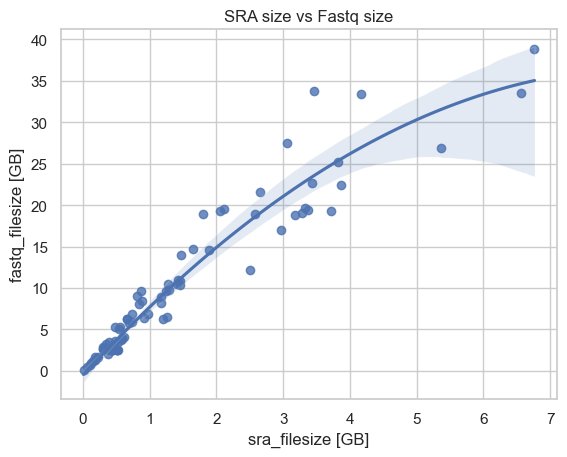

In [24]:
sns.regplot(data=hpc_df, x="sra_filesize [GB]", y="fastq_filesize [GB]", order=2).set_title('SRA size vs Fastq size');

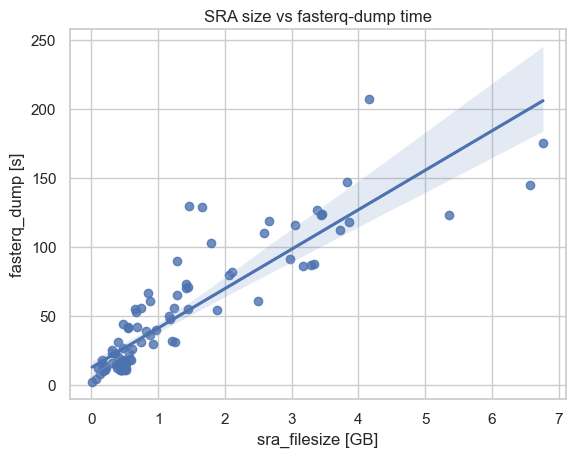

In [25]:
sns.regplot(data=hpc_df, x="sra_filesize [GB]", y="fasterq_dump [s]", order=1).set_title('SRA size vs fasterq-dump time');

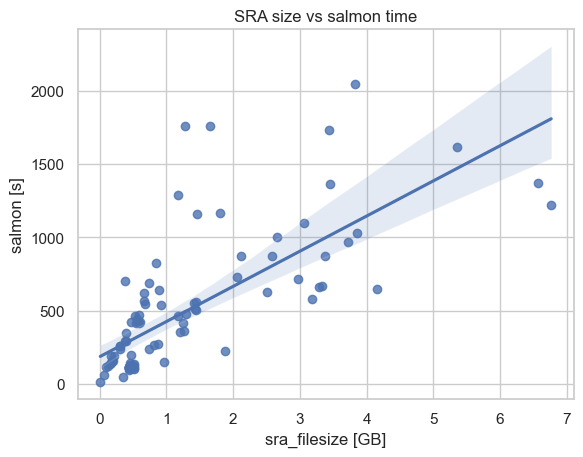

In [26]:
sns.regplot(data=hpc_df, x="sra_filesize [GB]", y="salmon [s]", order=1).set_title('SRA size vs salmon time');

## Cloud vs HPC comparision

In [27]:
cloud_hpc_df = pd.concat(
    [ec2_df.drop(["sra_filesize [GB]", "fastq_filesize [GB]"], axis=1),
     hpc_df.drop(["sra_filesize [GB]", "fastq_filesize [GB]"], axis=1)],
    axis=1, keys=['Cloud', 'HPC']).swaplevel(axis=1)

cloud_hpc_df

,prefetch [s],fasterq_dump [s],salmon [s],deseq2 [s],prefetch [s],fasterq_dump [s],salmon [s],deseq2 [s]
,Cloud,Cloud,Cloud,Cloud,HPC,HPC,HPC,HPC
DRR023416,13,13,126,9,28,18,106,11
DRR023433,15,13,147,9,29,18,141,11
DRR023434,17,14,137,10,29,12,122,10
DRR023438,11,14,129,10,196,11,116,10
DRR023440,15,13,135,9,27,11,112,11
...,...,...,...,...,...,...,...,...
SRR9202759,11,27,305,9,16,23,261,10
SRR9202761,16,110,543,25,104,41,444,12
SRR9202764,25,102,854,10,111,67,825,10


In [28]:
def get_rel_performance(df, step_name):
    step_df = df[f"{step_name} [s]"].copy()
    step_df["diff"] = step_df["HPC"] - step_df["Cloud"]
    step_df["rel_diff"] = step_df["diff"] / (step_df["HPC"] + step_df["Cloud"]) * 2 * 100
    step_df = step_df.sort_values("diff", ascending=False)
    rel_perf = sum(step_df["rel_diff"]) / step_df.shape[0]
    return step_df, rel_perf

def print_mean_and_max_exec_time(step_df):
    hpc = step_df["HPC"]
    cloud = step_df["Cloud"]
    print("Execution times:")
    print(f"HPC: mean={hpc.mean():.2f}s, max={hpc.max():.2f}s")
    print(f"Cloud: mean={cloud.mean():.2f}s, max={cloud.max():.2f}s")

In [29]:
prefetch_df, prefetch_perf = get_rel_performance(cloud_hpc_df, "prefetch")
print_mean_and_max_exec_time(prefetch_df)
print(f"HPC is {prefetch_perf:.1f}% slower than Cloud")
prefetch_df

Execution times:
HPC: mean=127.52s, max=1176.00s
Cloud: mean=37.86s, max=234.00s
HPC is 87.3% slower than Cloud


,Cloud,HPC,diff,rel_diff
ERR3445707,221,1176,955,136.721546
SRR1286927,96,959,863,163.601896
ERR3289032,234,858,624,114.285714
ERR3445695,151,769,618,134.347826
DRR122021,97,694,597,150.948167
...,...,...,...,...
SRR6511484,7,13,6,60.000000
SRR6511505,5,11,6,75.000000
SRR9202759,11,16,5,37.037037
SRR8256079,3,7,4,80.000000


In [30]:
fasterq_df, fasterq_perf = get_rel_performance(cloud_hpc_df, "fasterq_dump")
print_mean_and_max_exec_time(fasterq_df)
print(f"HPC is {fasterq_perf:.1f}% slower than Cloud")
fasterq_df

Execution times:
HPC: mean=48.29s, max=207.00s
Cloud: mean=83.43s, max=342.00s
HPC is -30.1% slower than Cloud


,Cloud,HPC,diff,rel_diff
SRR2656883,6,12,6,66.666667
SRR6511491,9,15,6,50.000000
SRR8256082,12,18,6,40.000000
DRR023416,13,18,5,32.258065
DRR023433,13,18,5,32.258065
...,...,...,...,...
SRR11114650,199,55,-144,-113.385827
SRR8358616,196,50,-146,-118.699187
ERR3445707,297,145,-152,-68.778281
SRR14961871,289,124,-165,-79.903148


In [31]:
salmon_df, salmon_perf = get_rel_performance(cloud_hpc_df, "salmon")
print_mean_and_max_exec_time(salmon_df)
print(f"HPC is {salmon_perf:.1f}% slower than Cloud")
salmon_df

Execution times:
HPC: mean=484.73s, max=2045.00s
Cloud: mean=578.15s, max=2575.00s
HPC is -19.4% slower than Cloud


,Cloud,HPC,diff,rel_diff
SRR5052460,1622,1762,140,8.274232
SRR8663470,1160,1286,126,10.302535
SRR18016633,1737,1758,21,1.201717
SRR16541678,15,12,-3,-22.222222
DRR023433,147,141,-6,-4.166667
...,...,...,...,...
SRR1286927,1202,875,-327,-31.487723
ERR3289032,1567,1220,-347,-24.901328
SRR8632816,2575,2045,-530,-22.943723
SRR8632814,2289,1730,-559,-27.817865


In [32]:
deseq2_df, deseq2_perf = get_rel_performance(cloud_hpc_df, "deseq2")
print_mean_and_max_exec_time(deseq2_df)
print(f"HPC is {deseq2_perf:.1f}% slower than Cloud")
deseq2_df

Execution times:
HPC: mean=10.21s, max=12.00s
Cloud: mean=10.90s, max=36.00s
HPC is -1.7% slower than Cloud


,Cloud,HPC,diff,rel_diff
DRR023416,9,11,2,20.000000
SRR8358638,9,11,2,20.000000
DRR023433,9,11,2,20.000000
DRR023627,9,11,2,20.000000
DRR023609,9,11,2,20.000000
...,...,...,...,...
SRR8256072,23,11,-12,-70.588235
SRR9202761,25,12,-13,-70.270270
SRR11114650,26,12,-14,-73.684211
SRR1286927,30,12,-18,-85.714286
